![Semillero Astrofisica](../../logo.png)

---
# Ecuaciones Diferenciales Parciales: Navier Stockes 


Carlos Andrés del Valle (cdelv@unal.edu.co)

---

Vamos a resolver la ecuación Navier Stockes incompresible en 2D al rededor de un cilindro.

\begin{equation}
    \begin{split}
        & \rho\left(\frac{\partial}{\partial t}\vec{V}+\vec{V}\cdot\nabla\vec{V}\right) = -\vec{\nabla}P +\mu\nabla^2\vec{V} \\
        & \vec{\nabla}\cdot \vec{V} = 0
    \end{split}
\end{equation}

Vamos a entrenar sobre un conjunto de datos que corresponden a una calle de vórtices de Von Karmann. 

ESte ejemplo se discute con más detalle en el paper https://doi.org/10.1016/j.jcp.2018.10.045 sección 4.1.1.

In [1]:
!pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 143 kB 39.5 MB/s 
     |████████████████████████████████| 100 kB 11.4 MB/s 


In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import re

#Usar doble precisión si la GPU lo soporta. Float32 por defecto.
#dde.config.real.set_float64()

DeepXDE backend not selected or invalid. Use tensorflow.compat.v1.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.



## 1. Funciones para cargar los datos 

In [3]:
from google.colab import drive
drive.mount('/drive')
# true values
C1true = 1.0
C2true = 0.01

# Cargar Datos de Entrenamiento
def load_training_data(num):
    data = loadmat("/drive/My Drive/Colab Notebooks/cylinder_nektar_wake.mat")
    U_star = data["U_star"]  # N x 2 x T
    P_star = data["p_star"]  # N x T
    t_star = data["t"]  # T x 1
    X_star = data["X_star"]  # N x 2
    N = X_star.shape[0]
    T = t_star.shape[0]
    # Rearrange Data
    XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
    YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
    TT = np.tile(t_star, (1, N)).T  # N x T
    UU = U_star[:, 0, :]  # N x T
    VV = U_star[:, 1, :]  # N x T
    PP = P_star  # N x T
    x = XX.flatten()[:, None]  # NT x 1
    y = YY.flatten()[:, None]  # NT x 1
    t = TT.flatten()[:, None]  # NT x 1
    u = UU.flatten()[:, None]  # NT x 1
    v = VV.flatten()[:, None]  # NT x 1
    p = PP.flatten()[:, None]  # NT x 1
    # training domain: X × Y = [1, 8] × [−2, 2] and T = [0, 7]
    data1 = np.concatenate([x, y, t, u, v, p], 1)
    data2 = data1[:, :][data1[:, 2] <= 7]
    data3 = data2[:, :][data2[:, 0] >= 1]
    data4 = data3[:, :][data3[:, 0] <= 8]
    data5 = data4[:, :][data4[:, 1] >= -2]
    data_domain = data5[:, :][data5[:, 1] <= 2]
    # choose number of training points: num = 7000
    idx = np.random.choice(data_domain.shape[0], num, replace=False)
    x_train = data_domain[idx, 0:1]
    y_train = data_domain[idx, 1:2]
    t_train = data_domain[idx, 2:3]
    u_train = data_domain[idx, 3:4]
    v_train = data_domain[idx, 4:5]
    p_train = data_domain[idx, 5:6]
    return [x_train, y_train, t_train, u_train, v_train, p_train]

Mounted at /drive


## 2. Definir la Ecuación a Resolver

In [4]:
# Tamaño del Dominio
Lx_min, Lx_max = 1.0, 8.0
Ly_min, Ly_max = -2.0, 2.0

# Tiempo
tmax = 7.0

# Variables para descubrir
C1 = dde.Variable(0.0) # densidad
C2 = dde.Variable(0.0) # viscosidad

def Navier_Stokes_Equation(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]
    p = y[:, 2:3]
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    du_t = dde.grad.jacobian(y, x, i=0, j=2)
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)
    dv_t = dde.grad.jacobian(y, x, i=1, j=2)
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
    continuity = du_x + dv_y
    x_momentum = C1*(du_t + u * du_x + v * du_y) + dp_x - C2 * (du_xx + du_yy)
    y_momentum = C1*(dv_t + u * dv_x + v * dv_y) + dp_y - C2 * (dv_xx + dv_yy)
    return [continuity, x_momentum, y_momentum]

## 3. Definir Dominio de la Ecuación

In [5]:
#X × Y = [1, 8] × [−2, 2]
space_domain = dde.geometry.Rectangle([Lx_min, Ly_min], [Lx_max, Ly_max])

# T = [0, 7]
time_domain = dde.geometry.TimeDomain(0, 7)

geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

## 4. Definir Condiciones Iniciales y de Frontera

~~~python
class deepxde.icbc.boundary_conditions.PointSetBC(points, 
                                                  values, 
                                                  component=0, 
                                                  batch_size=None, 
                                                  shuffle=True)
~~~

**Parameters:**	
- **points** – An array of points where the corresponding target values are known and used for training.
- **values** – An array of values that gives the exact solution of the problem.
- **component** – The output component satisfying this BC.
- **batch_size** – The number of points per minibatch, or None to return all points. This is only supported for the backend PyTorch.
- **shuffle** – Randomize the order on each pass through the data when batching.

https://deepxde.readthedocs.io/en/latest/modules/deepxde.icbc.html?highlight=PointSetBC#deepxde.icbc.boundary_conditions.PointSetBC

In [6]:
# 7000 datos de entrenamiento
[ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num=7000)
ob_xyt = np.hstack((ob_x, ob_y, ob_t))

observe_u = dde.icbc.PointSetBC(ob_xyt, ob_u, component=0)
observe_v = dde.icbc.PointSetBC(ob_xyt, ob_v, component=1)

## 5. Crear Datos de Entrenamiento

vamos a crear los datos de entrenamiento

In [7]:
data = dde.data.TimePDE(
    geomtime,
    Navier_Stokes_Equation,
    [observe_u, observe_v],
    num_domain=700,
    num_boundary=200,
    num_initial=100,
    anchors=ob_xyt, # Acá añadimos los datos de entrenamiento
    train_distribution="pseudo"
)

## 6. Crear la Red Neuronal


In [8]:
layer_size = [3] + [50]*6 + [3]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

## 7. Compilar y Entrenar el Modelo


In [9]:
# Modelo
model = dde.Model(data, net)

# Calback para ver el valor de las variables de entrenamiento
# Lo guarda a un archivo
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue([C1, C2], period=100, filename=fnamevar)

# Optimizador Adam
model.compile("adam", lr=1e-3, external_trainable_variables=[C1, C2])

loss_history, train_state = model.train(
    iterations=10000, callbacks=[variable], display_every=1000, disregard_previous_best=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.106269 s



/usr/local/lib/python3.7/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,


'compile' took 3.912732 s

Initializing variables...
Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [5.50e-02, 8.91e-04, 7.89e-03, 3.49e-01, 3.48e-01]    [5.50e-02, 8.91e-04, 7.89e-03, 3.49e-01, 3.48e-01]    []  
1000      [5.06e-04, 1.79e-05, 2.77e-05, 2.21e-03, 3.31e-03]    [5.06e-04, 1.79e-05, 2.77e-05, 2.21e-03, 3.31e-03]    []  
2000      [2.44e-04, 8.59e-06, 1.13e-05, 1.22e-03, 1.49e-03]    [2.44e-04, 8.59e-06, 1.13e-05, 1.22e-03, 1.49e-03]    []  
3000      [1.59e-04, 4.83e-06, 7.37e-06, 8.50e-04, 1.03e-03]    [1.59e-04, 4.83e-06, 7.37e-06, 8.50e-04, 1.03e-03]    []  
4000      [1.40e-04, 3.10e-06, 5.59e-06, 6.09e-04, 7.33e-04]    [1.40e-04, 3.10e-06, 5.59e-06, 6.09e-04, 7.33e-04]    []  
5000      [1.40e-04, 1.86e-06, 3.24e-06, 4.63e-04, 5.73e-04]    [1.40e-04, 1.86e-06, 3.24e-06, 4.63e-04, 5.73e-04]    []  
6000      [1.77e-04, 7.99e-07, 1.51e-06, 3.97e-04, 4.15e-04]

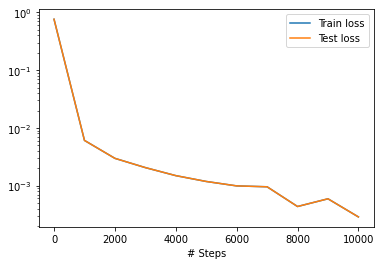

In [10]:
dde.saveplot(model.losshistory, model.train_state, issave=False, isplot=True)

In [11]:
model.compile("adam", lr=1e-4, external_trainable_variables=[C1, C2])

loss_history, train_state = model.train(
    epochs=10000, callbacks=[variable], display_every=1000, disregard_previous_best=True)

Compiling model...
'compile' took 1.683383 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
10000     [4.34e-05, 1.62e-08, 1.27e-07, 1.23e-04, 1.21e-04]    [4.34e-05, 1.62e-08, 1.27e-07, 1.23e-04, 1.21e-04]    []  
11000     [3.85e-05, 1.76e-16, 2.98e-16, 1.07e-04, 1.05e-04]    [3.85e-05, 1.76e-16, 2.98e-16, 1.07e-04, 1.05e-04]    []  
12000     [3.43e-05, 7.52e-13, 1.53e-12, 9.20e-05, 9.40e-05]    [3.43e-05, 7.52e-13, 1.53e-12, 9.20e-05, 9.40e-05]    []  
13000     [3.13e-05, 2.97e-10, 2.55e-09, 8.21e-05, 8.54e-05]    [3.13e-05, 2.97e-10, 2.55e-09, 8.21e-05, 8.54e-05]    []  
14000     [2.81e-05, 1.36e-10, 8.22e-10, 7.13e-05, 7.81e-05]    [2.81e-05, 1.36e-10, 8.22e-10, 7.13e-05, 7.81e-05]    []  
15000     [2.58e-05, 4.06e-12, 2.43e-11, 6.40e-05, 7.24e-05]    [2.58e-05, 4.06e-12, 2.43e-11, 6.40e-05, 7.24e-05]    []  
16000     [2.39e-05, 5.93e-13, 1.07e-12, 5.84e-05, 6.77e-05]    [2.

## 8. Visualizar la Solución

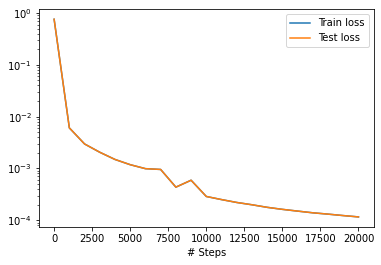

In [12]:
dde.saveplot(model.losshistory, model.train_state, issave=False, isplot=True)

In [13]:
f = model.predict(ob_xyt, operator=Navier_Stokes_Equation)
print("Mean residual:", np.mean(np.absolute(f)))

Mean residual: 0.0010580961


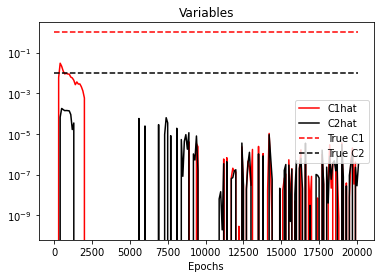

In [14]:
# Graficar las variables que queremos descubrir
lines = open(fnamevar, "r").readlines()

Chat = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)
l, c = Chat.shape
plt.semilogy(range(0, l * 100, 100), Chat[:, 0], "r-")
plt.semilogy(range(0, l * 100, 100), Chat[:, 1], "k-")
plt.semilogy(range(0, l * 100, 100), np.ones(Chat[:, 0].shape) * C1true, "r--")
plt.semilogy(range(0, l * 100, 100), np.ones(Chat[:, 1].shape) * C2true, "k--")
plt.legend(["C1hat", "C2hat", "True C1", "True C2"], loc="right")
plt.xlabel("Epochs")
plt.title("Variables")
plt.show()

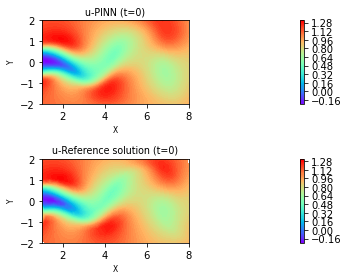

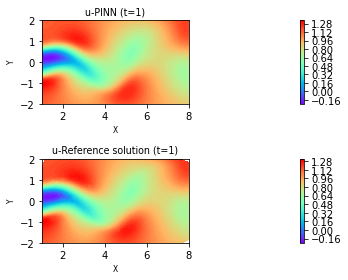

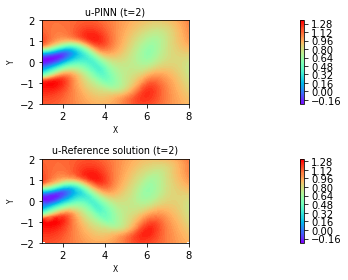

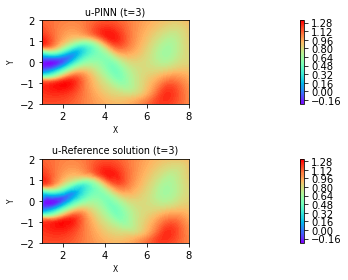

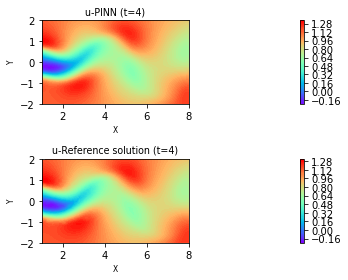

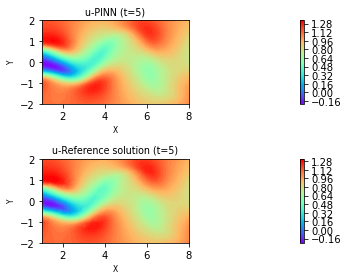

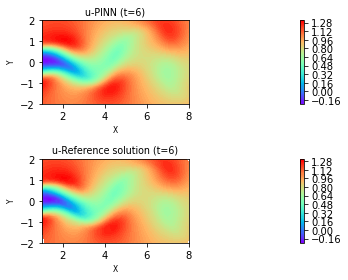

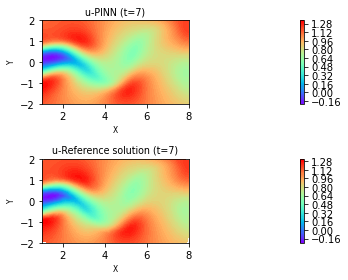

In [15]:
# Plot the velocity distribution of the flow field:
for t in range(0, 8):
    [ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num=140000)
    xyt_pred = np.hstack((ob_x, ob_y, t * np.ones((len(ob_x), 1))))
    uvp_pred = model.predict(xyt_pred)
    x_pred, y_pred, t_pred = xyt_pred[:, 0], xyt_pred[:, 1], xyt_pred[:, 2]
    u_pred, v_pred, p_pred = uvp_pred[:, 0], uvp_pred[:, 1], uvp_pred[:, 2]
    x_true = ob_x[ob_t == t]
    y_true = ob_y[ob_t == t]
    u_true = ob_u[ob_t == t]
    fig, ax = plt.subplots(2, 1)
    cntr0 = ax[0].tricontourf(x_pred, y_pred, u_pred, levels=80, cmap="rainbow")
    cb0 = plt.colorbar(cntr0, ax=ax[0])
    cntr1 = ax[1].tricontourf(x_true, y_true, u_true, levels=80, cmap="rainbow")
    cb1 = plt.colorbar(cntr1, ax=ax[1])
    ax[0].set_title("u-PINN " + "(t=" + str(t) + ")", fontsize=9.5)
    ax[0].axis("scaled")
    ax[0].set_xlabel("X", fontsize=7.5, family="Arial")
    ax[0].set_ylabel("Y", fontsize=7.5, family="Arial")
    ax[1].set_title("u-Reference solution " + "(t=" + str(t) + ")", fontsize=9.5)
    ax[1].axis("scaled")
    ax[1].set_xlabel("X", fontsize=7.5, family="Arial")
    ax[1].set_ylabel("Y", fontsize=7.5, family="Arial")
    fig.tight_layout()
    plt.show()